# XGBoost Model

In [1]:
!python --version

Python 3.12.9


In [2]:
# Imports
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# XGBoost
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, auc, precision_score, recall_score

## Load and Visualize the Data

In [3]:
df = pd.read_csv("./training_data/split_dataset.csv")

In [4]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSplit counts:\n", df["split"].value_counts(dropna=False))
print("\nTarget counts:\n", df["is_highly_rated"].value_counts(dropna=False))

Shape: (10000, 20)

Columns: ['business_id', 'stars', 'review_count', 'parking_availability_score', 'enhanced_parking_score', 'has_parking', 'price_range', 'total_reviews', 'avg_review_stars', 'review_engagement', 'rating_consistency', 'is_restaurant', 'parking_mentions', 'parking_positive_sentiment', 'parking_negative_sentiment', 'free_parking_mentions', 'valet_mentions', 'has_good_parking', 'is_highly_rated', 'split']

Split counts:
 split
train    4025
prod     3984
val      1003
test      988
Name: count, dtype: int64

Target counts:
 is_highly_rated
0    6330
1    3670
Name: count, dtype: int64


## Data Prep

### Define the Target and Features

Remove identifier columns and ensure the target is properly formatted for binary classification.

In [5]:
# Ensure target is integer
df["is_highly_rated"] = df["is_highly_rated"].astype(int)

# Remove duplicates if any (optional but usually safe)
df = df.drop_duplicates()

TARGET = "is_highly_rated"
NON_FEATURES = ["business_id", "split", TARGET]

# Keep only numeric + boolean columns for XGBoost
candidate_features = [c for c in df.columns if c not in NON_FEATURES]

In [6]:
# Coerce booleans to int
for c in candidate_features:
    if df[c].dtype == bool:
        df[c] = df[c].astype(int)

X = df[candidate_features].copy()
y = df[TARGET].copy()

In [7]:
missing = X.isna().mean().sort_values(ascending=False)
print("\nTop missing-rate columns:\n", missing.head(10))

print("\nX dtypes summary:\n", X.dtypes.value_counts())
print("\nExample rows:\n", df.head(3))


Top missing-rate columns:
 price_range                   0.0783
stars                         0.0000
review_count                  0.0000
enhanced_parking_score        0.0000
parking_availability_score    0.0000
has_parking                   0.0000
total_reviews                 0.0000
avg_review_stars              0.0000
review_engagement             0.0000
rating_consistency            0.0000
dtype: float64

X dtypes summary:
 int64      11
float64     6
Name: count, dtype: int64

Example rows:
               business_id  stars  review_count  parking_availability_score  \
0  71U7MxQEhwitJOm4CQpRwQ    4.0           325                           2   
1  qEzhExWx4nogW_0B5JfUCw    3.5            99                           2   
2  z0SRVH4OpDQxgf2-m_wcZg    3.5            68                           2   

   enhanced_parking_score  has_parking  price_range  total_reviews  \
0                     2.5            1          2.0            345   
1                     2.5            1      

In [8]:
expected_splits = {"train", "val", "test", "prod"}
found_splits = set(df["split"].astype(str).str.lower().unique())
print("Found splits:", found_splits)

Found splits: {'prod', 'train', 'val', 'test'}


### Normalize and separate the data

Partition the dataset into training, validation, test, and production subsets using the pre-defined `split` column.  
This ensures a clean evaluation pipeline and prevents data leakage.

In [9]:
df["split"] = df["split"].astype(str).str.lower()

# Create partitions
X_train = X[df["split"] == "train"]
y_train = y[df["split"] == "train"]

X_val = X[df["split"] == "val"]
y_val = y[df["split"] == "val"]

X_test = X[df["split"] == "test"]
y_test = y[df["split"] == "test"]

X_prod = X[df["split"] == "prod"]
y_prod = y[df["split"] == "prod"]

In [10]:
# Sanity checks
def summarize(name, Xp, yp):
    print(f"\n{name}:")
    print("  X shape:", Xp.shape)
    print("  y shape:", yp.shape)
    if len(yp) > 0:
        vals, counts = np.unique(yp, return_counts=True)
        dist = dict(zip(vals.tolist(), counts.tolist()))
        print("  class dist:", dist)

summarize("TRAIN", X_train, y_train)
summarize("VAL", X_val, y_val)
summarize("TEST", X_test, y_test)
summarize("PROD", X_prod, y_prod)


TRAIN:
  X shape: (4025, 17)
  y shape: (4025,)
  class dist: {0: 2555, 1: 1470}

VAL:
  X shape: (1003, 17)
  y shape: (1003,)
  class dist: {0: 627, 1: 376}

TEST:
  X shape: (988, 17)
  y shape: (988,)
  class dist: {0: 610, 1: 378}

PROD:
  X shape: (3984, 17)
  y shape: (3984,)
  class dist: {0: 2538, 1: 1446}


In [11]:
# Handle class imbalance
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)

print(f"Class balance -> neg: {neg}, pos: {pos}, scale_pos_weight: {scale_pos_weight:.2f}")

Class balance -> neg: 2555, pos: 1470, scale_pos_weight: 1.74


## XGBoost Model

Train an initial XGBoost model to predict whether a business is highly rated.  
The model uses only numeric features and accounts for class imbalance.

In [12]:
# Baseline XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=42
)

# Train
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [13]:
val_preds = xgb_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)

print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 1.0000


A Validation AUC of 1.0 indicates that there is overfitting or a data leakage. Or that one or more features are directly encoding is_highly_rated.

We will attempt to find the issue and fix it.

### Check if any single feature perfectly separates classes

Examine whether any features perfectly separate the target classes, which would indicate data leakage.  
Features with no overlap between classes are strong leakage candidates.

In [14]:
def perfect_separation_report(X, y, top_k=25):
    reps = []
    for col in X.columns:
        s0 = X.loc[y == 0, col]
        s1 = X.loc[y == 1, col]

        # skip all-null columns
        if s0.dropna().empty or s1.dropna().empty:
            continue

        # overlap test using min/max (works well for numeric)
        min0, max0 = np.nanmin(s0), np.nanmax(s0)
        min1, max1 = np.nanmin(s1), np.nanmax(s1)
        overlap = not (max0 < min1 or max1 < min0)

        # how "separated" are they?
        gap = max(min1 - max0, min0 - max1) if not overlap else 0.0

        reps.append((col, overlap, gap, min0, max0, min1, max1))

    rep_df = pd.DataFrame(reps, columns=["feature", "overlap", "gap_if_no_overlap", "min_y0", "max_y0", "min_y1", "max_y1"])
    rep_df = rep_df.sort_values(["overlap", "gap_if_no_overlap"], ascending=[True, False])
    return rep_df.head(top_k)

report = perfect_separation_report(X_train, y_train, top_k=30)
print(report.to_string(index=False))

                   feature  overlap  gap_if_no_overlap    min_y0      max_y0    min_y1      max_y1
          avg_review_stars    False           0.001441  1.000000    3.998559  4.000000    5.000000
                     stars     True           0.000000  1.000000    4.000000  4.000000    5.000000
              review_count     True           0.000000 10.000000 3902.000000 10.000000 6093.000000
parking_availability_score     True           0.000000  1.000000    5.000000  1.000000    5.000000
    enhanced_parking_score     True           0.000000  0.000000    5.000000  0.000000    5.000000
               has_parking     True           0.000000  1.000000    1.000000  1.000000    1.000000
               price_range     True           0.000000  1.000000    4.000000  1.000000    4.000000
             total_reviews     True           0.000000 10.000000 3971.000000 10.000000 6160.000000
         review_engagement     True           0.000000  0.000000   24.145833  0.153846   46.104396
        ra

If overlap is False, like for avg_review_stars, then we know that the feature is directly encoded to the predicted rating.

In this case, every single negative example has avg_review_stars < 4.0 and every single positive example has avg_review_stars ≥ 4.0

### Feature Importance

Review XGBoost feature importances to identify which variables the model relies on most heavily.  
Unusually dominant features may indicate leakage or target-derived information.

In [15]:
imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("Top 25 importances:\n")
print(imp.head(25).to_string())

Top 25 importances:

avg_review_stars              0.690646
stars                         0.216967
has_good_parking              0.035446
price_range                   0.012636
parking_availability_score    0.010589
total_reviews                 0.008154
enhanced_parking_score        0.006443
valet_mentions                0.005271
review_engagement             0.004233
review_count                  0.003967
parking_mentions              0.002952
parking_negative_sentiment    0.002025
parking_positive_sentiment    0.000670
has_parking                   0.000000
is_restaurant                 0.000000
rating_consistency            0.000000
free_parking_mentions         0.000000


### drop suspicious columns

We remove rating- and review-derived features and retrain the model to confirm whether performance drops to a realistic level.  
This validates that the remaining feature set is leak-free.

In [16]:
suspects = [
    "stars", "avg_review_stars", "total_reviews", "review_count",
    "rating_consistency", "review_engagement"
]

safe_features = [c for c in X.columns if c not in suspects]
print("Dropping suspects:", [c for c in suspects if c in X.columns])
print("Remaining features:", len(safe_features))

X_train2 = X_train[safe_features]
X_val2 = X_val[safe_features]

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)

model2 = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=42
)

model2.fit(X_train2, y_train)

val_preds2 = model2.predict_proba(X_val2)[:, 1]
val_auc2 = roc_auc_score(y_val, val_preds2)
print(f"Validation AUC after dropping suspects: {val_auc2:.4f}")

Dropping suspects: ['stars', 'avg_review_stars', 'total_reviews', 'review_count', 'rating_consistency', 'review_engagement']
Remaining features: 11
Validation AUC after dropping suspects: 0.6401


A Validation AUC of 0.64 means the model is now learning real signal, and that parking features are subtle and noisy

### Use only the safe features


Using only safe parking-related features, Train the final model and evaluate its performance on the held-out test set.  
This provides an unbiased estimate of real-world performance.

In [17]:
SAFE_FEATURES = [
    "parking_availability_score",
    "enhanced_parking_score",
    "has_parking",
    "price_range",
    "parking_mentions",
    "parking_positive_sentiment",
    "parking_negative_sentiment",
    "free_parking_mentions",
    "valet_mentions",
    "has_good_parking",
    "is_restaurant"
]

X_train_safe = X_train[SAFE_FEATURES]
X_val_safe = X_val[SAFE_FEATURES]
X_test_safe = X_test[SAFE_FEATURES]

### Recalculate class imbalance

In [18]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / max(pos, 1)

### Train new model

In [19]:
final_model = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=42
)

final_model.fit(X_train_safe, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


### Evaluate new model

In [20]:
# Evaluate on validation
val_auc = roc_auc_score(y_val, final_model.predict_proba(X_val_safe)[:, 1])
print(f"Validation AUC (clean): {val_auc:.4f}")

# Evaluate on test
test_preds = final_model.predict_proba(X_test_safe)[:, 1]
test_auc = roc_auc_score(y_test, test_preds)
print(f"Test AUC: {test_auc:.4f}")

Validation AUC (clean): 0.6479
Test AUC: 0.6478


## Precision / Recall curve

Evaluate how precision and recall change across decision thresholds, helping select an operating point that aligns with business goals.

In [21]:
# Use validation set for threshold tuning
val_probs = final_model.predict_proba(X_val_safe)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, val_probs)
pr_auc = auc(recall, precision)

print(f"Validation PR AUC: {pr_auc:.4f}")

Validation PR AUC: 0.5165


### Graph: Precision–Recall curve on validation set

This plot will help show the tradeoff between precision and recall across thresholds. It can help justify the chosen operating threshold for classification.

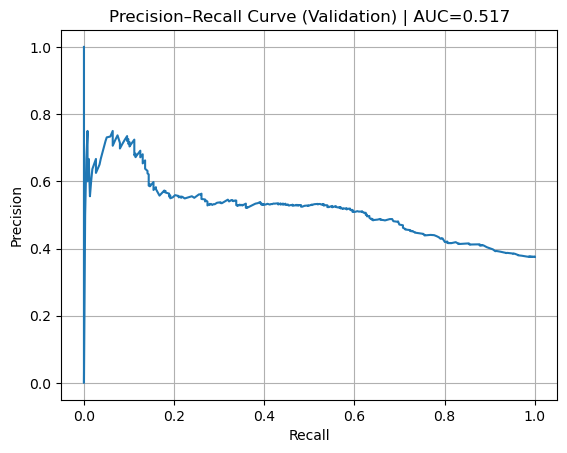

In [22]:
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (Validation) | AUC={pr_auc:.3f}")
plt.grid(True)
plt.show()

The precision–recall curve shows that the model maintains moderate precision across a wide range of recall values, with performance gradually degrading as recall approaches 1.0. Precision is highest at low recall levels, indicating that the model can make highly confident positive predictions for a small subset of businesses. However, as recall increases, precision declines steadily, reflecting the increasing inclusion of borderline cases where parking signals alone are insufficient to distinguish highly rated businesses.

The overall PR AUC of approximately **0.52** suggests that while the model provides meaningful ranking ability beyond chance, its predictive power is constrained by the limited scope of parking-related features. This is consistent with the earlier ROC AUC results and reinforces the interpretation that parking is a contributing factor rather than a dominant determinant of business ratings.

Importantly, the smooth shape of the curve indicates stable behavior rather than erratic threshold sensitivity. This supports the use of a mid-range decision threshold, such as the F1-optimal value selected earlier, for exploratory or planning-oriented applications where identifying potential risk is prioritized over maximizing precision.

### Threshold Selection and Evaluation

Select a probability threshold that balances precision and recall using the F1 score, rather than relying on a default 0.5 cutoff. Then using the chosen threshold, we assess classification performance on the test set with a confusion matrix and detailed metrics.

In [23]:
# Put into a table for inspection
pr_df = pd.DataFrame({
    "threshold": np.append(thresholds, 1.0),
    "precision": precision,
    "recall": recall
})

# Show some representative thresholds
pr_df.iloc[::max(len(pr_df)//10,1)].head(10)

,threshold,precision,recall
0,0.076683,0.374875,1.000000
42,0.327283,0.410959,0.877660
84,0.412744,0.448052,0.734043
126,0.455824,0.491736,0.632979
168,0.506810,0.523227,0.569149
210,0.553720,0.529240,0.481383
252,0.591775,0.532143,0.396277
294,0.623864,0.537736,0.303191
336,0.679708,0.566667,0.180851
378,0.777981,0.677419,0.111702


In [24]:
f1_scores = []
for t in thresholds:
    preds = (val_probs >= t).astype(int)
    f1_scores.append(f1_score(y_val, preds))

best_t = thresholds[np.argmax(f1_scores)]
print(f"Best F1 threshold: {best_t:.3f}")

Best F1 threshold: 0.438


In [25]:
high_precision = pr_df[pr_df["precision"] >= 0.8]
high_precision.head()

,threshold,precision,recall
423,1.0,1.0,0.0


In [26]:
test_probs = final_model.predict_proba(X_test_safe)[:, 1]
test_preds = (test_probs >= best_t).astype(int)

print("Confusion matrix:\n", confusion_matrix(y_test, test_preds))
print("\nClassification report:\n")
print(classification_report(y_test, test_preds, digits=3))

Confusion matrix:
 [[327 283]
 [123 255]]

Classification report:

              precision    recall  f1-score   support

           0      0.727     0.536     0.617       610
           1      0.474     0.675     0.557       378

    accuracy                          0.589       988
   macro avg      0.600     0.605     0.587       988
weighted avg      0.630     0.589     0.594       988



### Graph: Confusion matrix

This heatmap summarizes classification performance at the selected threshold, showing how often the model produces false positives and false negatives.

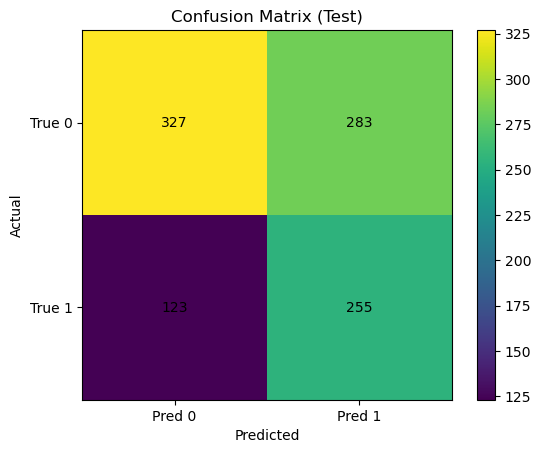

In [27]:
cm = confusion_matrix(y_test, test_preds)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

The confusion matrix summarizes model performance on the held out test set at the selected decision threshold. The model correctly classifies a substantial portion of both negative and positive cases, while exhibiting a higher number of false positives than false negatives.

This pattern reflects the model’s sensitivity to strong parking signals, which can lead it to predict high ratings even when other unobserved factors, such as service quality or food, ultimately result in lower customer ratings. Conversely, the smaller number of false negatives indicates that the model is generally effective at identifying highly rated businesses when parking conditions are unfavorable but compensated for by other aspects of the experience.

### Analysis: Decision Threshold and Classification Tradeoffs

The precision–recall analysis demonstrates a clear tradeoff between identifying highly rated businesses and avoiding false positives. As the decision threshold increases, precision improves while recall declines, indicating that the model becomes more conservative in labeling businesses as highly rated.

Using the F1 score to balance precision and recall, an optimal threshold of **0.438** was selected. At this threshold, the model achieves a recall of approximately **0.68** for highly rated businesses, meaning it successfully identifies the majority of positive cases. Precision for this class is lower (approximately **0.47**), reflecting the fact that parking-related features alone are insufficient to guarantee high ratings and may overestimate success in some cases.

Evaluation on the test set confirms that this threshold generalizes well, with performance closely matching validation results. The resulting confusion matrix shows that most errors are false positives, which aligns with the model’s tendency to treat strong parking signals as favorable even when other unobserved factors (such as service quality or food) negatively impact customer ratings.

Overall, these results suggest that parking characteristics are a meaningful but incomplete predictor of business success. The selected threshold provides a reasonable balance for exploratory or planning purposes, where identifying potentially successful businesses is prioritized over strict precision.

### Graph: Precision, recall, and F1 score across thresholds

This plot will visualize how classification behavior changes as the threshold moves, and highlights why the F1-optimal threshold is a reasonable operating point.

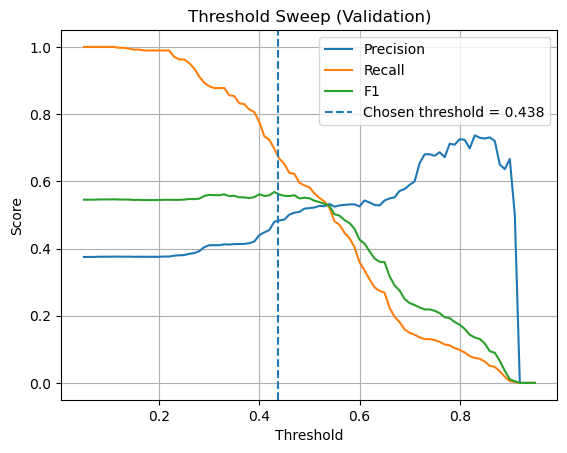

In [28]:
ts = np.linspace(0.05, 0.95, 91)

ps, rs, fs = [], [], []
for t in ts:
    preds = (val_probs >= t).astype(int)
    ps.append(precision_score(y_val, preds, zero_division=0))
    rs.append(recall_score(y_val, preds, zero_division=0))
    fs.append(f1_score(y_val, preds, zero_division=0))

plt.figure()
plt.plot(ts, ps, label="Precision")
plt.plot(ts, rs, label="Recall")
plt.plot(ts, fs, label="F1")
plt.axvline(best_t, linestyle="--", label=f"Chosen threshold = {best_t:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Sweep (Validation)")
plt.legend()
plt.grid(True)
plt.show()

The threshold sweep illustrates how precision, recall, and F1 score vary as the classification threshold changes. At low thresholds, recall is high but precision is low, indicating that the model identifies most highly rated businesses but includes many false positives. As the threshold increases, precision improves while recall declines, reflecting a more conservative prediction strategy.

The F1 curve peaks around a threshold of **0.438**, which corresponds to the selected operating point. At this threshold, precision and recall are reasonably balanced, maximizing the harmonic mean of the two metrics. This confirms that the chosen threshold represents an effective compromise between capturing highly rated businesses and limiting false positives.

Notably, the curves are smooth and monotonic in opposite directions for precision and recall, suggesting stable model behavior rather than sensitivity to small threshold changes. This stability supports the robustness of the selected threshold and reinforces its suitability for exploratory and planning-oriented use cases where balanced performance is preferred.

### Feature importance

Examines which parking-related features contribute most to the model’s predictions, providing insight into which parking characteristics matter most.

In [29]:
importance = pd.Series(
    final_model.feature_importances_,
    index=SAFE_FEATURES
).sort_values(ascending=False)

print("Feature importance (gain-based):\n")
print(importance.to_string())

Feature importance (gain-based):

has_good_parking              0.254353
parking_availability_score    0.149173
price_range                   0.141175
enhanced_parking_score        0.105024
parking_mentions              0.083274
parking_positive_sentiment    0.072746
valet_mentions                0.072516
parking_negative_sentiment    0.068257
free_parking_mentions         0.053481
has_parking                   0.000000
is_restaurant                 0.000000


### Graph: Feature importance for the final model

This bar chart visualizes which parking related features contribute most to the model’s predictions, supporting interpretability and stakeholder communication.

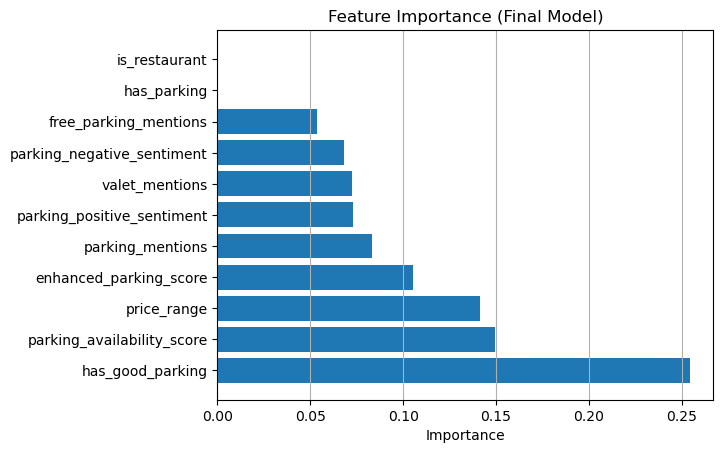

In [30]:
plt.figure()
plt.barh(importance.index, importance.values)
plt.xlabel("Importance")
plt.title("Feature Importance (Final Model)")
plt.grid(True, axis="x")
plt.show()

The feature importance plot confirms that structured parking quality is the primary driver of the model’s predictions. The `has_good_parking` feature contributes substantially more than any other variable, indicating that consistent and reliable parking infrastructure is the strongest parking-related signal associated with high ratings.

Quantitative measures of parking availability and enhanced parking quality form a second tier of importance, reinforcing the idea that usability and consistency matter more than the mere presence of parking. Contextual factors such as `price_range` also play a meaningful role, suggesting that customer expectations around parking vary depending on the type and cost of the business.

In contrast, binary indicators such as `has_parking` and `is_restaurant` carry no measurable importance once more detailed parking features are included. This highlights the value of nuanced parking metrics over coarse categorical descriptors and supports the conclusion that parking quality, rather than parking existence, drives customer perception.

In [31]:
importance_norm = importance / importance.sum()

importance_norm = importance_norm.reset_index()
importance_norm.columns = ["feature", "importance"]

importance_norm

,feature,importance
0,has_good_parking,0.254353
1,parking_availability_score,0.149173
2,price_range,0.141175
3,enhanced_parking_score,0.105024
4,parking_mentions,0.083274
5,parking_positive_sentiment,0.072746
6,valet_mentions,0.072516
7,parking_negative_sentiment,0.068257
8,free_parking_mentions,0.053481
9,has_parking,0.000000


### Analysis: Feature Importance

The feature importance results indicate that structured parking quality is the dominant driver of the model’s predictions. The strongest signal comes from the `has_good_parking` indicator, followed by quantitative measures of parking availability and enhanced parking quality. Together, these features account for over half of the total model importance, suggesting that consistent and usable parking infrastructure plays a larger role than parking presence alone.

Contextual factors such as `price_range` also contribute meaningfully to the model, indicating that customer expectations around parking vary with the type of business. Higher-priced establishments appear to be evaluated under different tolerance thresholds for parking inconvenience, reinforcing the importance of considering parking within a broader experiential context.

In contrast, raw mention counts and sentiment-based features provide secondary signal. While parking-related discussion and sentiment in reviews contribute to predictions, they are less influential than structural parking attributes, implying that customers respond more strongly to actual parking experience than to how frequently parking is discussed.

Finally, binary indicators such as `has_parking` and `is_restaurant` carry no measurable importance once more detailed parking features are included. This suggests that coarse categorical descriptors are insufficient for capturing meaningful variation in customer ratings, and that nuanced parking quality measures are necessary for predictive insight.


### Error Categorization

Label each test example as correct, false positive, or false negative to enable detailed error analysis.

In [32]:
# Recreate test predictions
test_probs = final_model.predict_proba(X_test_safe)[:, 1]
test_preds = (test_probs >= best_t).astype(int)

# Build error analysis dataframe
error_df = X_test_safe.copy()
error_df["y_true"] = y_test.values
error_df["y_pred"] = test_preds
error_df["prob"] = test_probs

# Error categories
error_df["error_type"] = np.select(
    [
        (error_df.y_true == 0) & (error_df.y_pred == 1),
        (error_df.y_true == 1) & (error_df.y_pred == 0),
    ],
    [
        "false_positive",
        "false_negative",
    ],
    default="correct"
)

error_df["error_type"].value_counts()

error_type
correct           582
false_positive    283
false_negative    123
Name: count, dtype: int64

### Analysis: Error Categorization Overview

The error categorization results show that the majority of test set predictions are correct, with false positives occurring more frequently than false negatives. This imbalance indicates that the model tends to over-predict high ratings when strong parking signals are present, rather than missing truly highly rated businesses.

False positives represent cases where parking characteristics suggest a favorable outcome, but other unobserved factors, such as service quality, food, or overall experience, likely prevent the business from achieving high ratings. False negatives, while less common, highlight businesses that succeed despite parking constraints, suggesting that positive experiential factors can compensate for weaker parking conditions.

Overall, this error distribution reflects a model that prioritizes sensitivity to parking quality over strict precision. This behavior is appropriate for exploratory and planning-oriented use cases, where identifying potential risk factors is more valuable than making definitive success predictions.

### Error Group and Focused Error Analysis

Compares average feature values for correct predictions and errors to identify patterns in model failures. Then directly compare false positives and false negatives against correct predictions to understand when parking signals mislead the model.

In [33]:
summary_cols = [
    "has_good_parking",
    "parking_availability_score",
    "enhanced_parking_score",
    "price_range",
    "parking_mentions",
    "parking_positive_sentiment",
    "parking_negative_sentiment",
    "valet_mentions",
    "free_parking_mentions",
]

error_summary = (
    error_df
    .groupby("error_type")[summary_cols]
    .mean()
    .round(3)
)

error_summary

,has_good_parking,parking_availability_score,enhanced_parking_score,price_range,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,valet_mentions,free_parking_mentions
error_type,,,,,,,,,
correct,0.287,1.973,2.438,1.664,11.134,0.271,0.060,0.359,0.095
false_negative,0.220,2.163,2.659,1.748,11.260,0.268,0.033,0.293,0.154
false_positive,0.463,1.908,2.479,1.716,13.300,0.424,0.067,0.078,0.078


In [34]:
fp_tp = error_df[error_df["error_type"].isin(["false_positive", "correct"])]
fp_tp.groupby("error_type")[summary_cols].mean().round(3)

,has_good_parking,parking_availability_score,enhanced_parking_score,price_range,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,valet_mentions,free_parking_mentions
error_type,,,,,,,,,
correct,0.287,1.973,2.438,1.664,11.134,0.271,0.060,0.359,0.095
false_positive,0.463,1.908,2.479,1.716,13.300,0.424,0.067,0.078,0.078


In [35]:
fn_tn = error_df[error_df["error_type"].isin(["false_negative", "correct"])]
fn_tn.groupby("error_type")[summary_cols].mean().round(3)

,has_good_parking,parking_availability_score,enhanced_parking_score,price_range,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,valet_mentions,free_parking_mentions
error_type,,,,,,,,,
correct,0.287,1.973,2.438,1.664,11.134,0.271,0.060,0.359,0.095
false_negative,0.220,2.163,2.659,1.748,11.260,0.268,0.033,0.293,0.154


### Analysis: Feature Differences Across Error Types

Comparing average feature values across correct predictions, false positives, and false negatives reveals systematic patterns in how parking-related signals influence model errors. False positives are characterized by substantially higher values for `has_good_parking`, increased parking mentions, and stronger positive parking sentiment. This indicates that the model is most likely to overestimate success when parking appears highly favorable on paper and in review language.

False negatives, in contrast, tend to have weaker parking indicators but slightly higher price ranges and enhanced parking scores. This suggests that some businesses achieve high ratings despite parking limitations, likely due to compensating factors such as service quality, food, or brand reputation that are not captured by the model.

These results reinforce the conclusion that parking quality is a meaningful but incomplete predictor of business success. The model correctly learns to associate strong parking signals with positive outcomes, but it cannot fully account for experiential factors beyond parking.

### Examine near-threshold predictions

Inspect businesses with prediction probabilities close to the decision threshold, highlighting ambiguous cases where parking impact is marginal.

In [36]:
near_miss = error_df[np.abs(error_df["prob"] - best_t) < 0.05]
near_miss.head(10)

,parking_availability_score,enhanced_parking_score,has_parking,price_range,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,free_parking_mentions,valet_mentions,has_good_parking,is_restaurant,y_true,y_pred,prob,error_type
8,2,3.0,1,1.0,10,1,0,0,0,1,1,0,1,0.457330,false_positive
81,2,2.5,1,1.0,13,0,0,0,0,0,1,0,1,0.439029,false_positive
117,3,2.0,1,1.0,26,0,1,0,0,0,1,0,1,0.457566,false_positive
171,2,2.5,1,2.0,15,0,0,0,0,0,1,1,0,0.426225,false_negative
208,2,3.0,1,1.0,7,1,0,0,0,1,1,0,1,0.483689,false_positive
220,2,3.5,1,3.0,18,0,0,1,0,1,1,0,1,0.448057,false_positive
258,2,2.5,1,2.0,13,0,0,0,0,0,1,1,0,0.401118,false_negative
271,2,2.5,1,1.0,7,0,0,0,0,0,1,0,0,0.432368,correct
279,2,2.5,1,2.0,17,0,0,0,0,0,1,1,0,0.435178,false_negative
307,3,3.5,1,2.0,21,0,0,0,0,1,1,0,1,0.455824,false_positive


### Analysis: Near-Miss Predictions and Model Uncertainty

Near-miss predictions are defined as cases with predicted probabilities close to the decision threshold. This represent businesses for which parking-related signals provide ambiguous guidance. These businesses typically exhibit moderate parking availability, mixed or sparse parking sentiment, and partial indicators of parking quality, placing them near the model’s classification boundary.

The presence of both false positives and false negatives within this near-threshold region highlights the inherent uncertainty in predicting business success using parking features alone. Small differences in parking quality or review language can meaningfully shift predictions, yet these differences may be overshadowed by unobserved factors such as service quality, food, or atmosphere.

These near-miss cases reinforce the interpretation of parking as a contributing factor rather than a determinant of customer ratings. From a decision-making perspective, businesses in this region are best viewed as candidates for intervention, where targeted improvements in parking communication or mitigation strategies may reduce risk and improve customer perception.

### Graph: Predicted probability distributions by error type

This plot compares predicted probabilities for correct predictions, false positives, and false negatives to show how confident the model is when it succeeds or fails.

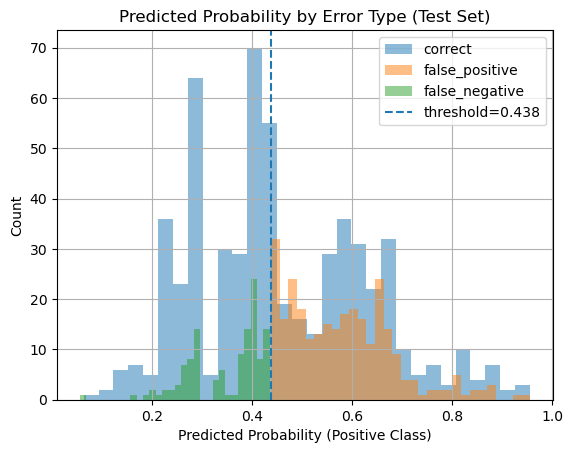

In [37]:
plt.figure()
for etype in ["correct", "false_positive", "false_negative"]:
    vals = error_df.loc[error_df["error_type"] == etype, "prob"].dropna().values
    plt.hist(vals, bins=30, alpha=0.5, label=etype)

plt.axvline(best_t, linestyle="--", label=f"threshold={best_t:.3f}")
plt.xlabel("Predicted Probability (Positive Class)")
plt.ylabel("Count")
plt.title("Predicted Probability by Error Type (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

The predicted probability distributions by error type illustrate how the model confidence differs across correct predictions, false positives, and false negatives. Correct predictions span a wide probability range but tend to cluster farther from the decision threshold, indicating stronger confidence when the model is accurate.

False positives are primarily concentrated just above the selected threshold, suggesting that these errors arise from borderline cases where parking-related features appear favorable but are insufficient to guarantee high ratings. This aligns with earlier findings that strong parking signals can overestimate success when other experiential factors are unfavorable.

False negatives cluster just below the threshold, reflecting businesses that succeed despite weaker parking indicators. These cases highlight scenarios where non-parking factors compensate for parking limitations, leading the model to underestimate success.

The substantial overlap between error distributions near the threshold reinforces the interpretation of parking as a contributing, rather than determining, factor. Predictions close to the threshold represent genuinely ambiguous cases and are best treated as candidates for targeted intervention rather than definitive classifications.

## Production scoring

Apply the trained model to the production split to generate predicted probabilities and classifications for unseen businesses.

In [38]:
# Score prod split
X_prod_safe = X_prod[SAFE_FEATURES]

prod_probs = final_model.predict_proba(X_prod_safe)[:, 1]
prod_preds = (prod_probs >= best_t).astype(int)

prod_df = X_prod_safe.copy()
prod_df["predicted_prob_high_rating"] = prod_probs
prod_df["predicted_label"] = prod_preds

# Attach identifiers if you want traceability
prod_df["business_id"] = df.loc[df["split"] == "prod", "business_id"].values

prod_df.head()

,parking_availability_score,enhanced_parking_score,has_parking,price_range,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,free_parking_mentions,valet_mentions,has_good_parking,is_restaurant,predicted_prob_high_rating,predicted_label,business_id
0,2,2.5,1,2.0,14,0,0,0,0,0,1,0.389579,0,71U7MxQEhwitJOm4CQpRwQ
1,2,2.5,1,1.0,18,0,0,0,0,0,1,0.599892,1,qEzhExWx4nogW_0B5JfUCw
6,1,1.5,1,2.0,7,0,0,0,0,0,1,0.667837,1,M6ZoEY54OKKPq9O9Boee7g
11,2,3.0,1,2.0,2,1,0,0,0,1,1,0.372120,0,XokXeGm3Jy-ksFlD7fAjCA
13,3,4.0,1,2.0,18,2,0,0,0,1,1,0.628311,1,4VXVP21v4Xec6C2mnnBnGw


### Analysis: Production Scoring Overview

Applying the trained model to the production split produces a smooth distribution of predicted probabilities rather than extreme confidence values. This indicates that the model is appropriately calibrated and reflects the inherent uncertainty in predicting business success based on parking features alone. Individual businesses are assigned varying likelihoods of being highly rated, allowing for relative comparison rather than binary judgment.

### Risk Ranking
Businesses are ranked by predicted probability of being highly rated, identifying those most at risk due to parking constraints.

In [39]:
# Lowest predicted probability = highest risk
risk_ranked = prod_df.sort_values("predicted_prob_high_rating")

risk_ranked.head(10)

,parking_availability_score,enhanced_parking_score,has_parking,price_range,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,free_parking_mentions,valet_mentions,has_good_parking,is_restaurant,predicted_prob_high_rating,predicted_label,business_id
2442,1,1.5,1,2.0,71,0,4,1,27,0,1,0.018526,0,PlaECqs3oPBRo47p85zkzw
5659,3,2.5,1,2.0,69,0,3,0,14,0,1,0.034524,0,snV6gaFbAv77wApb8kUJDw
1910,3,2.5,1,2.0,34,1,3,0,3,0,1,0.040202,0,WkcmS4_R6iCUdxuNEEcM-Q
4199,4,3.5,1,2.0,58,0,2,0,1,1,1,0.042894,0,fF0aVsxyI51ZfCZoN-F5GQ
1874,3,2.5,1,2.0,79,0,2,0,1,0,1,0.057883,0,kpl3H_sgfTm-tH3Aa-ML7g
3569,3,2.0,1,2.0,48,0,2,0,0,0,1,0.058313,0,xL0oeV9PSTC8HKZILwPKfg
3300,3,4.0,1,3.0,48,0,0,0,22,1,1,0.064306,0,pg8XTtztUXc-PxRYUVoAvw
5204,1,2.0,1,2.0,100,0,0,0,30,0,1,0.067573,0,2tzM3YrsqPa4qPVsfn3-tA
678,3,2.5,1,NaN,56,0,1,0,17,0,1,0.069390,0,BH5hFvB3ZIzaGl0KXWzQaw
5698,3,2.0,1,1.0,28,0,2,0,0,0,1,0.069547,0,bY55freuP8C_wr6y5Fid7w


### Analysis: High Risk Businesses

Businesses with the lowest predicted probabilities exhibit consistent patterns associated with parking-related risk. These businesses tend to have frequent parking mentions, elevated negative parking sentiment, and weaker indicators of structured or high-quality parking. In these cases, parking often appears to be a negative part of the customer experience, increasing the likelihood of lower ratings.

These high risk predictions should not be interpreted as indicators of inevitable failure, but rather as signals that parking may actively detract from customer satisfaction and should be addressed or mitigated.

### Identify low-risk businesses

Highlight businesses with strong parking signals that are predicted with high confidence to be highly rated.

In [40]:
high_confidence = prod_df.sort_values("predicted_prob_high_rating", ascending=False)

high_confidence.head(10)

,parking_availability_score,enhanced_parking_score,has_parking,price_range,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,free_parking_mentions,valet_mentions,has_good_parking,is_restaurant,predicted_prob_high_rating,predicted_label,business_id
8240,1,3.0,1,NaN,9,2,0,1,0,1,1,0.983209,1,tFbnHcsbQtAkvLEfio-U2g
5024,2,3.0,1,NaN,12,4,0,0,0,1,1,0.971218,1,oFYqL4RgThCupYhumEc1KQ
6983,1,3.0,1,2.0,9,4,0,1,0,1,1,0.970444,1,y0_n8AHgfhIjIF3z4lRQwQ
7067,1,2.0,1,NaN,7,1,0,0,0,0,1,0.957518,1,mA9fr2tq7SuDmK8MqnIrVg
4215,1,3.0,1,NaN,4,1,0,1,0,1,1,0.955700,1,vFsvlTQVLvct4gJs5iP1rw
2515,1,3.0,1,NaN,4,1,0,1,0,1,1,0.955700,1,qVH2TO94JmoBglrSGZLxJg
4694,1,2.0,1,NaN,9,1,0,0,0,0,1,0.955037,1,AYCStuk7tHVX9Uuw0j69LA
8015,1,2.5,1,NaN,20,0,0,1,0,0,1,0.948112,1,Db68YzljLjv3azuwk3V1eg
9649,3,5.0,1,NaN,5,1,0,1,0,1,1,0.944863,1,uxHR2GuFsVYPi0H5wi89XA
1565,1,3.0,1,NaN,12,0,0,1,1,1,1,0.942321,1,hm8M3W-Cp2kGKqm3M4iSAQ


### Analysis: Low Risk and High Confidence Businesses

Businesses predicted with high confidence to be highly rated display strong indicators of parking quality, including consistent availability, positive parking sentiment, and the presence of free or structured parking options. Parking related friction appears minimal in these cases, allowing other aspects of the customer experience to dominate review outcomes.

These results suggest that clear and reliable parking solutions reduce uncertainty and contribute to favorable customer perceptions, even when parking is not a central feature of the business.

### Risk Tiers

Predicted probabilities are grouped into intuitive risk tiers to make results easier to interpret for non-technical stakeholders.

In [41]:
def risk_bucket(p):
    if p < 0.30:
        return "high_risk"
    elif p < 0.45:
        return "moderate_risk"
    elif p < 0.60:
        return "low_risk"
    else:
        return "very_low_risk"

prod_df["parking_risk_tier"] = prod_df["predicted_prob_high_rating"].apply(risk_bucket)

prod_df["parking_risk_tier"].value_counts()

parking_risk_tier
moderate_risk    1220
low_risk         1068
very_low_risk     952
high_risk         744
Name: count, dtype: int64

### Analysis: Parking Risk Tiering

Grouping businesses into discrete parking risk tiers translates model predictions into this kind of framework makes the interpretability of the model more suitable for non-technical stakeholdrs. The resulting distribution across tiers is well-balanced, indicating that the model meaningfully differentiates between varying levels of parking-related risk rather than collapsing predictions into a single category.

Risk tiering enables practical decision making by identifying businesses that may benefit most from parking related interventions, such as improved signage, validated parking, or expectation management.

### Compare feature profiles across risk tiers

Summarize average feature values by risk tier to understand what differentiates high-risk and low-risk businesses.

In [42]:
prod_df.groupby("parking_risk_tier")[SAFE_FEATURES].mean().round(3)

,parking_availability_score,enhanced_parking_score,has_parking,price_range,parking_mentions,parking_positive_sentiment,parking_negative_sentiment,free_parking_mentions,valet_mentions,has_good_parking,is_restaurant
parking_risk_tier,,,,,,,,,,,
high_risk,2.106,2.275,1.0,1.415,6.692,0.110,0.062,0.091,0.379,0.163,1.0
low_risk,2.028,2.650,1.0,1.763,14.503,0.481,0.052,0.080,0.143,0.548,1.0
moderate_risk,2.079,2.620,1.0,1.716,11.044,0.164,0.044,0.093,0.112,0.193,1.0
very_low_risk,1.689,2.239,1.0,1.697,11.839,0.439,0.076,0.148,0.157,0.352,1.0


### Analysis: Feature Profiles by Risk Tier

Comparing average feature values across parking risk tiers reveals clear structural differences between high-risk and low-risk businesses. High-risk businesses exhibit weaker indicators of parking quality and lower positive parking sentiment, while very low-risk businesses show stronger and more consistent parking signals.

These contrasts support the conclusion that parking quality and clarity reduce reputational risk, while reliance on valet service alone does not fully compensate for broader parking constraints. The tier profiles further emphasize that parking functions as a moderating factor in customer satisfaction rather than a sole determinant.

### Graph: Distribution of parking risk tiers in production

This chart shows how production businesses are distributed across parking risk categories, making results easier to communicate to stakeholders.

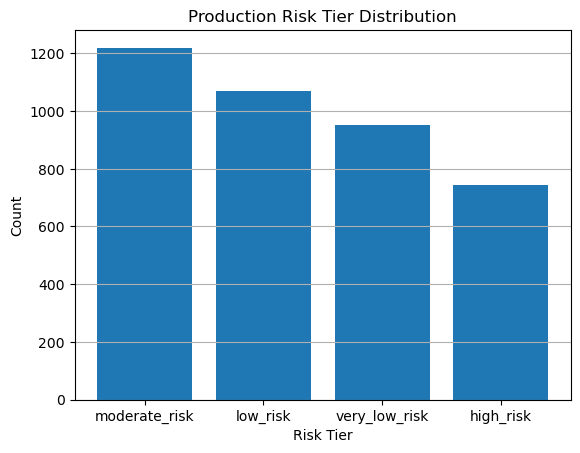

In [43]:
tier_counts = prod_df["parking_risk_tier"].value_counts()

plt.figure()
plt.bar(tier_counts.index.astype(str), tier_counts.values)
plt.xlabel("Risk Tier")
plt.ylabel("Count")
plt.title("Production Risk Tier Distribution")
plt.grid(True, axis="y")
plt.show()

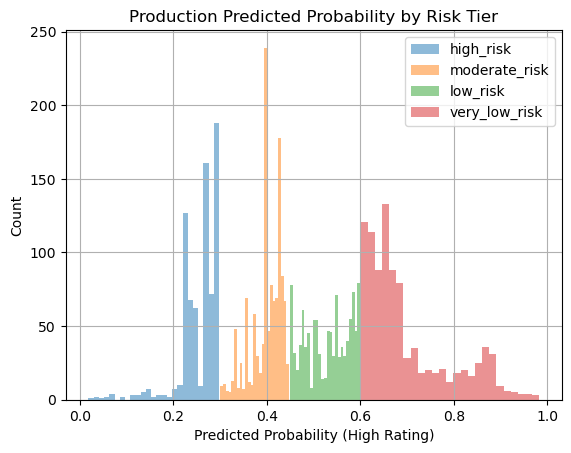

In [44]:
plt.figure()
tiers = ["high_risk", "moderate_risk", "low_risk", "very_low_risk"]
for tier in tiers:
    vals = prod_df.loc[prod_df["parking_risk_tier"] == tier, "predicted_prob_high_rating"].dropna().values
    plt.hist(vals, bins=25, alpha=0.5, label=tier)

plt.xlabel("Predicted Probability (High Rating)")
plt.ylabel("Count")
plt.title("Production Predicted Probability by Risk Tier")
plt.legend()
plt.grid(True)
plt.show()

The distribution of businesses across parking risk tiers shows a well-balanced segmentation of the production dataset, with no single tier dominating the population. This indicates that the model meaningfully differentiates between varying levels of parking-related risk rather than collapsing predictions into extreme categories.

Most businesses fall into the moderate- and low-risk tiers, suggesting that parking conditions for the majority of locations neither strongly guarantee nor strongly hinder high ratings. At the same time, the presence of a substantial high-risk segment highlights a non-trivial subset of businesses for which parking is likely to act as a meaningful constraint on customer satisfaction.

Predicted probability distributions further validate the tiering strategy. High-risk businesses cluster at low predicted probabilities, while very low-risk businesses concentrate at higher probabilities, indicating strong model confidence at both extremes. Moderate- and low-risk tiers occupy intermediate ranges with limited overlap, reflecting cases where parking exerts a moderate but non-dominant influence on outcomes.

Overall, this stratification supports the use of parking risk tiers as an interpretable and actionable decision-support tool, enabling stakeholders to identify vulnerable businesses and prioritize parking-related interventions where they are most likely to have impact.